# Baskerville HPC CO2 emissions

In [1]:
import pandas as pd
import yaml

from src.energy import get_energy_cpu, get_energy_gpu, get_energy_mem
from src.ci_calculator import CarbonIntensityCalculator

## Load data

In [2]:
# load Baskerville usage data
data = pd.read_csv("./data/Baskerville_total_commas.csv")
data["End Time"] = pd.to_datetime(data["End Time"])

# load Baskerville HPC config
cluster_info = yaml.safe_load(open("./data/hpc_config.yaml"))

In [3]:
# for aggregating by month/year
data["YYYY-MM"] = data["End Time"].apply(lambda x: x.strftime("%Y-%m"))
data["YYYY"] = data["End Time"].apply(lambda x: x.strftime("%Y"))

## Calculate energies

In [4]:
# calculate energies
data["E_cpu"] = data.apply(axis=1, func=get_energy_cpu, cluster_info=cluster_info) 
data["E_gpu"] = data.apply(axis=1, func=get_energy_gpu, cluster_info=cluster_info)
data["E_mem"] = data.apply(axis=1, func=get_energy_mem, cluster_info=cluster_info)
data["E_total_compute"] = data["E_cpu"] + data["E_gpu"] + data["E_mem"]
data["E_total"] = data["E_total_compute"] * cluster_info["PUE"] # PUE is ratio, still in kWh

<Axes: title={'center': 'Baskerville Energy Usage'}, xlabel='Year', ylabel='kWh'>

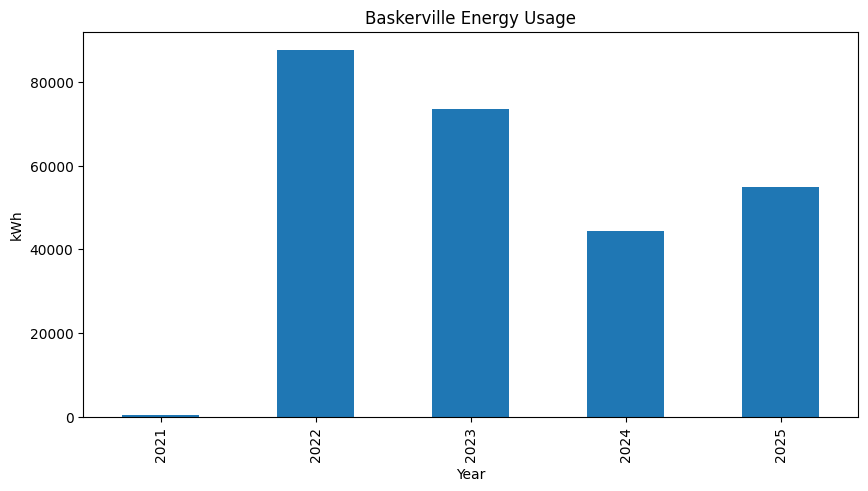

In [5]:
data.groupby("YYYY")["E_total_compute"].sum().plot(
    kind="bar", 
    title="Baskerville Energy Usage", 
    ylabel="kWh", 
    xlabel="Year", 
    figsize=(10,5)
)

## Calculate emissions using gas powered CHP carbon intensity

Noussan et al, 2024, Hourly electricity CO2 intensity profiles based on the real operation of large-scale natural gas combined cycle cogeneration plants, https://doi.org/10.1016/j.energy.2024.133424.

In [6]:
data["CO2_total_g_CHP"] = data["E_total"] * 300

In [7]:
data.to_csv("./data/Baskerville_ci_gas_chp.csv")

In [8]:
print(f"All time CO2 emissions using gas CHP CI: {data['CO2_total_g_CHP'].sum() / 1e6 :.2f} tonnes") # in tonnes CO2

All time CO2 emissions using gas CHP CI: 89.26 tonnes


In [9]:
print(f"Past 12 months CO2 emissions using gas CHP CI: {data.groupby('YYYY-MM')['CO2_total_g_CHP'].sum()['2024-09':].sum() / 1e6 :.2f} tonnes") # in tonnes CO2

Past 12 months CO2 emissions using gas CHP CI: 24.99 tonnes


In [10]:
data.groupby("YYYY")["CO2_total_g_CHP"].sum().apply(lambda x: x / 1e6).to_dict() # in tonnes CO2

{'2021': 0.16612441077425,
 '2022': 29.972465355355823,
 '2023': 25.133171768959013,
 '2024': 15.181560590602924,
 '2025': 18.805070075456324}

## Calculate emissions using yearly average carbon intensity

In [11]:
data["CO2_total_g_yearly"] = data["E_total"] * 124 # UK average 2024

In [12]:
data.to_csv("./data/Baskerville_ci_average_2024.csv")

In [13]:
print(f"All time CO2 emissions using UK average CI: {data['CO2_total_g_yearly'].sum() / 1e6 :.2f} tonnes") # in tonnes CO2

All time CO2 emissions using UK average CI: 36.89 tonnes


In [14]:
print(f"Past 12 months CO2 emissions using UK average CI: {data.groupby('YYYY-MM')['CO2_total_g_yearly'].sum()['2024-09':].sum() / 1e6 :.2f} tonnes") # in tonnes CO2

Past 12 months CO2 emissions using UK average CI: 10.33 tonnes


In [15]:
data.groupby("YYYY")["CO2_total_g_yearly"].sum().apply(lambda x: x / 1e6).to_dict() # in tonnes CO2

{'2021': 0.06866475645335667,
 '2022': 12.388619013547075,
 '2023': 10.388377664503059,
 '2024': 6.275045044115875,
 '2025': 7.77276229785528}

## Calculate emissions using daily average carbon intensity

In [16]:
# calculate daily average CI for each job
ci_calculator = CarbonIntensityCalculator()
data["CI"] = ci_calculator.get_carbon_intensity(data["End Time"])

Failed to get carbon intensity for 2023-10-21 17:17:13+00:00 from the API. Using UK average: 124 gCO2e/kWh. Error: list index out of range
Failed to get carbon intensity for 2023-10-21 18:18:24+00:00 from the API. Using UK average: 124 gCO2e/kWh. Error: list index out of range


In [17]:
data["CO2_total_g_daily"] = data["E_total"] * data["CI"] # daily average

In [18]:
data.to_csv("./data/Baskerville_ci_daily_ci.csv")

In [19]:
print(f"All time CO2 emissions using daily average CI: {data['CO2_total_g_daily'].sum() / 1e6 :.2f} tonnes") # in tonnes CO2

All time CO2 emissions using daily average CI: 41.18 tonnes


In [20]:
print(f"Past 12 months CO2 emissions using daily average CI: {data.groupby('YYYY-MM')['CO2_total_g_daily'].sum()['2024-09':].sum() / 1e6 :.2f} tonnes") # in tonnes CO2

Past 12 months CO2 emissions using daily average CI: 8.97 tonnes


In [21]:
yearly_averages = data.groupby("YYYY")["CO2_total_g_daily"].sum() / 1e6 # in tonnes CO2
yearly_averages = yearly_averages.to_dict()

yearly_averages

{'2021': 0.13404716834555,
 '2022': 17.996329041632286,
 '2023': 10.975992414555453,
 '2024': 5.077791925809139,
 '2025': 6.9971474995583645}

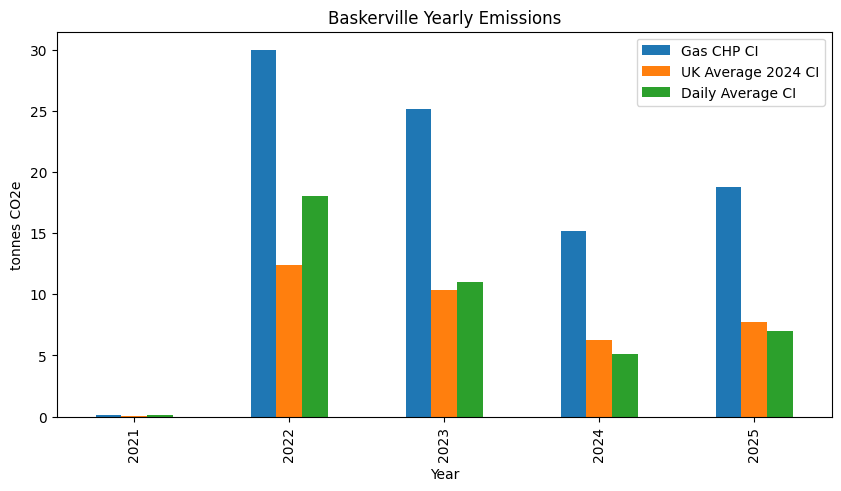

In [22]:
ax = data.groupby("YYYY")[["CO2_total_g_CHP", "CO2_total_g_yearly", "CO2_total_g_daily"]].sum().apply(lambda x: x/1e6).plot(
    kind="bar", 
    title="Baskerville Yearly Emissions", 
    ylabel="tonnes CO2e", 
    xlabel="Year", 
    figsize=(10,5),
)
ax.legend(["Gas CHP CI", "UK Average 2024 CI", "Daily Average CI"])